---
# **Mobile Price Prediction**
---

## Overview: 
1. **Objective:** Develop a predictive model for mobile phone prices.
2. **Target MAE:** Achieve a mean absolute error (MAE) ≤ 200.
3. **Purpose:** Enhance market transparency for consumers, retailers, and manufacturers.
4. **Impact:** Facilitate fair and competitive pricing strategies in the mobile phone market.

# Imports

In [73]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import shapiro

# Read CSV & Basic Info

In [58]:
# Reading in the dataset
data0 = pd.read_csv("Cellphone.csv")
# Creating a copy of dataset to make changes on.
data1 = data0.copy()

In [59]:
# Shape of the dataset (number of rows, number of columns)
data1.shape

(161, 14)

In [60]:
data1.head()

,Product_id,Price,Sale,weight,resoloution,ppi,cpu core,cpu freq,internal mem,ram,RearCam,Front_Cam,battery,thickness
0,203,2357,10,135.0,5.2,424,8,1.35,16.0,3.000,13.00,8.0,2610,7.4
1,880,1749,10,125.0,4.0,233,2,1.30,4.0,1.000,3.15,0.0,1700,9.9
2,40,1916,10,110.0,4.7,312,4,1.20,8.0,1.500,13.00,5.0,2000,7.6
3,99,1315,11,118.5,4.0,233,2,1.30,4.0,0.512,3.15,0.0,1400,11.0
4,880,1749,11,125.0,4.0,233,2,1.30,4.0,1.000,3.15,0.0,1700,9.9


In [61]:
# Column names
data1.columns

Index(['Product_id', 'Price', 'Sale', 'weight', 'resoloution', 'ppi',
       'cpu core', 'cpu freq', 'internal mem', 'ram', 'RearCam', 'Front_Cam',
       'battery', 'thickness'],
      dtype='object')

In [76]:
# Checking for missing data (0 means no missing data)
data1.isna().sum()

Product_id      0
Price           0
Sale            0
weight          0
resoloution     0
ppi             0
cpu core        0
cpu freq        0
internal mem    0
ram             0
RearCam         0
Front_Cam       0
battery         0
thickness       0
dtype: int64

In [63]:
# This function is very useful.
#1. RangeIndex: 161 entries, 0 to 160: (Total 161 rows. i.e., from 0 to 160)
#2. Data columns (total 14 columns): (Total 14 columns. i.e., from 0 to 13)
#3. #: Column index number
#4. Column: Column names
#5. Non-Null Count: Count of the values that are not null.
#6. Dtype: Datatype of the values present with in the column.
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Product_id    161 non-null    int64  
 1   Price         161 non-null    int64  
 2   Sale          161 non-null    int64  
 3   weight        161 non-null    float64
 4   resoloution   161 non-null    float64
 5   ppi           161 non-null    int64  
 6   cpu core      161 non-null    int64  
 7   cpu freq      161 non-null    float64
 8   internal mem  161 non-null    float64
 9   ram           161 non-null    float64
 10  RearCam       161 non-null    float64
 11  Front_Cam     161 non-null    float64
 12  battery       161 non-null    int64  
 13  thickness     161 non-null    float64
dtypes: float64(8), int64(6)
memory usage: 17.7 KB


# Story of Features

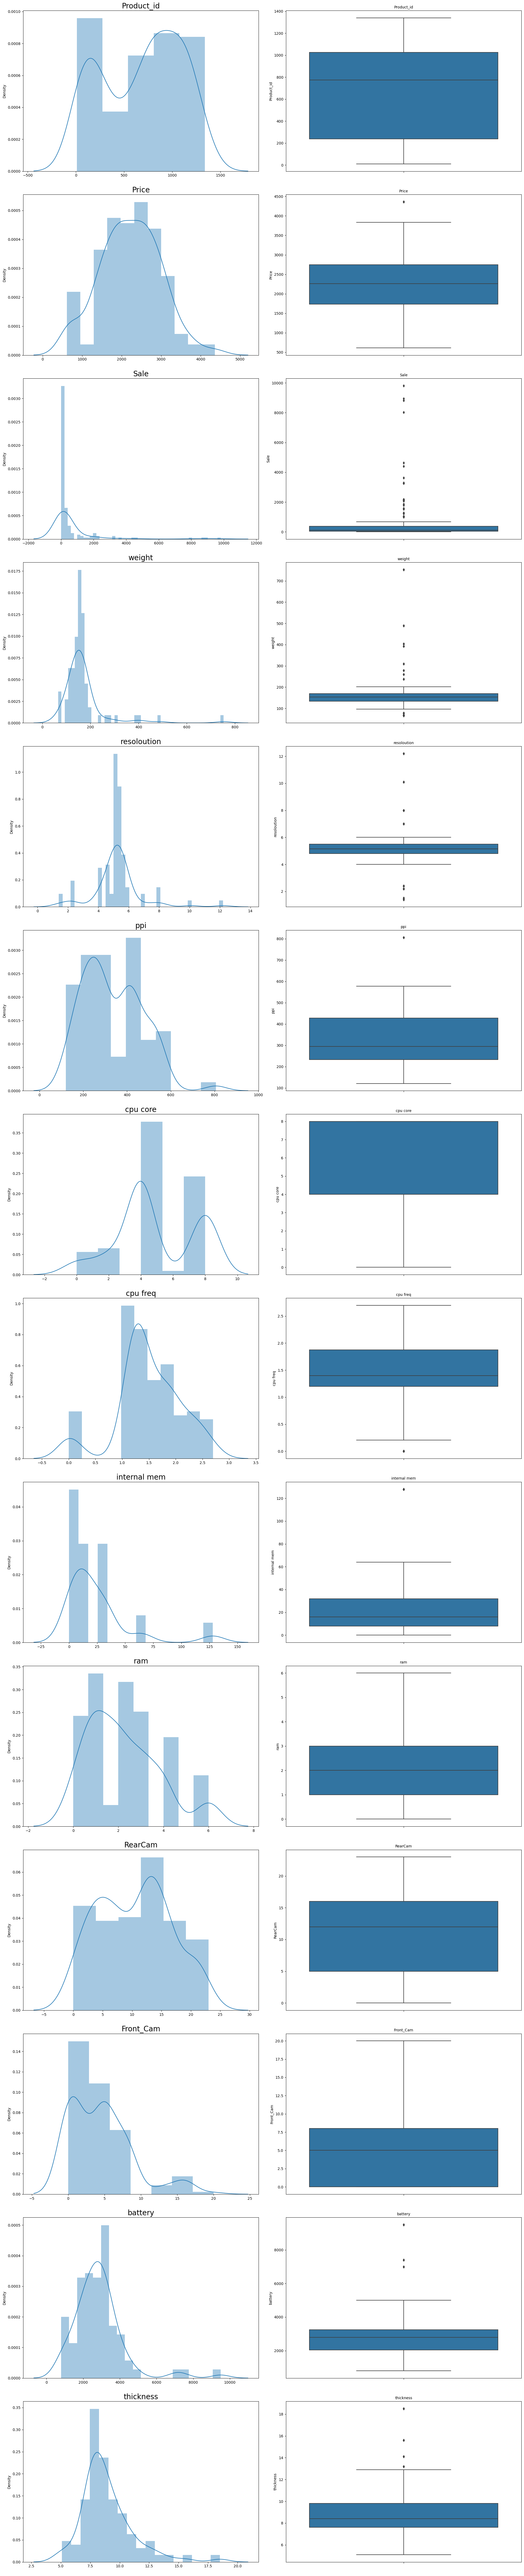

In [64]:
import warnings
# Suppress warnings
warnings.filterwarnings('ignore')
# Display distribution and boxplot for all columns in data1 in a single plot
fig, axes = plt.subplots(len(data1.columns), 2, figsize=(20, len(data1.columns) * 7))
for idx, col in enumerate(data1.columns):
    sns.distplot(data1[col], ax=axes[idx, 0])
    axes[idx, 0].set_xlabel(" ")
    axes[idx, 0].set_title(col, size=20)
    sns.boxplot(y=data1[col], ax=axes[idx, 1])
    axes[idx, 1].set_title(col, size=10)
plt.tight_layout()
plt.show()

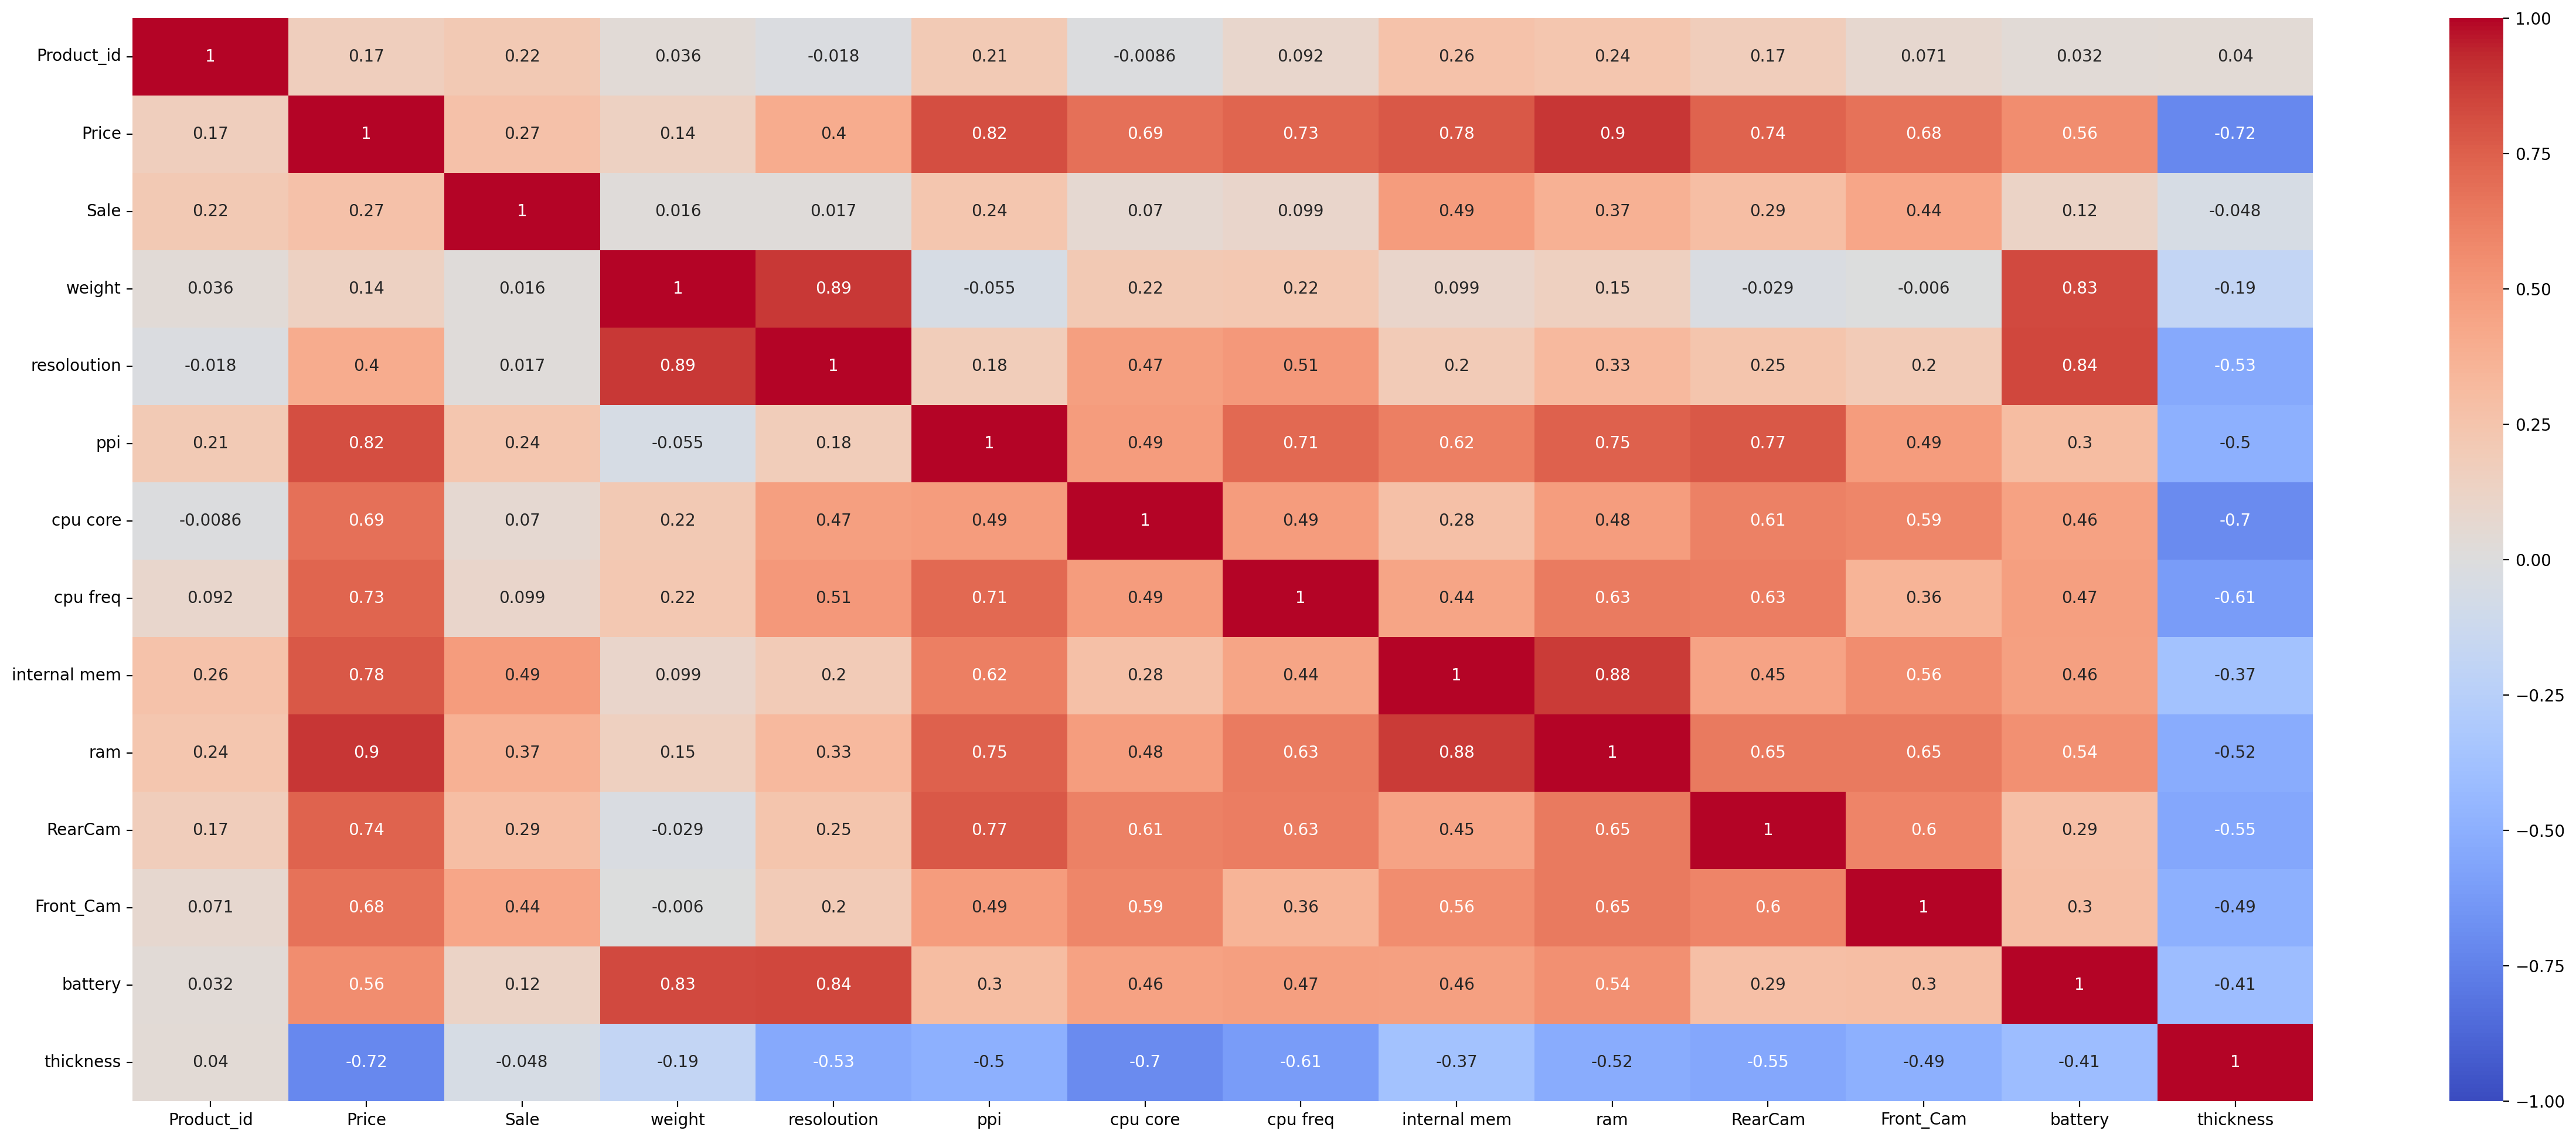

In [65]:
plt.figure(figsize=(30, 12), dpi=200)
sns.heatmap(data1.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

## Splitting target and independent features

In [66]:
# Seperating out the independent and dependent variables
X = data1.drop("Price", axis = 1)
X = X.drop("Product_id", axis = 1)
y = data1["Price"]

In [67]:
X.columns

Index(['Sale', 'weight', 'resoloution', 'ppi', 'cpu core', 'cpu freq',
       'internal mem', 'ram', 'RearCam', 'Front_Cam', 'battery', 'thickness'],
      dtype='object')

# **Handling Multicollinearity**

In [68]:
# Add a constant term (intercept) to your feature matrix
X_with_const = add_constant(X)
# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Features"] = X_with_const.columns
vif["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
# Display the VIF values
print(vif)

        Features         VIF
0          const  256.235570
1           Sale    1.761026
2         weight   22.708643
3    resoloution   22.231810
4            ppi    4.677627
5       cpu core    3.106053
6       cpu freq    3.895602
7   internal mem    6.805528
8            ram    9.289761
9        RearCam    3.915909
10     Front_Cam    2.778561
11       battery    9.437004
12     thickness    4.086291


#### Removing features with a Variance Inflation Factor (VIF) exceeding 10.

In [69]:
def remove_high_vif_features(X, vif_threshold=10):
    while (max_vif := pd.Series([variance_inflation_factor(add_constant(X).values, i) for i in range(add_constant(X).shape[1])], index=add_constant(X).columns).max()) > vif_threshold:
        feature_to_remove = pd.Series([variance_inflation_factor(add_constant(X).values, i) for i in range(add_constant(X).shape[1])], index=add_constant(X).columns).idxmax()
        if feature_to_remove == 'const':
            break
        X = X.drop(feature_to_remove, axis=1)
        print(f"Removed feature with high VIF: {feature_to_remove}, VIF = {max_vif}")    
    return X
# Remove high VIF features
X = remove_high_vif_features(X, vif_threshold=10)

## **Normality check**

In [70]:
import statsmodels.api as sm
# Fit linear regression and perform Shapiro-Wilk test on residuals
statistic, p_value = shapiro(sm.OLS(y, sm.add_constant(X)).fit().resid)
# Print results
print(f"Shapiro-Wilk Test Statistic: {statistic}\nP-value: {p_value}")
# Interpret the results
print("Residuals look Gaussian (fail to reject H0)" if p_value > 0.05 else "Residuals do not look Gaussian (reject H0)")

Shapiro-Wilk Test Statistic: 0.9877378344535828
P-value: 0.1718188375234604
Residuals look Gaussian (fail to reject H0)


####  Variables are normally distributed

## Splitting data

In [45]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

## Transforming the data

In [46]:
# Standardize the variables using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training Linear regression model

In [28]:
# Linear model fit and predict
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)
# Evaluation metrics
r2, rmse, mae, mape = r2_score(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred)), mean_absolute_error(y_test, y_pred), np.mean(np.abs((y_test - y_pred) / y_test)) * 100
# Adjusted R-squared
adjusted_r2 = 1 - (1 - r2) * ((X_train.shape[0] + X_test.shape[0] - 1) / (X_train.shape[0] + X_test.shape[0] - X_train.shape[1] - 1))
print(f"r2_score: {r2}\nRMSE: {rmse}\nMAE: {mae}\nAdjusted R2: {adjusted_r2}\nMAPE: {mape:.2f}%")

r2_score: 0.9268483347618663
RMSE: 188.14959735172243
MAE: 159.65125136000754
Adjusted R2: 0.9209171186614771
MAPE: 7.61%


## Regression Equation

In [47]:
from sklearn.linear_model import LinearRegression
# Create and fit Linear Regression model
model = LinearRegression().fit(X, y)
# Get predicted values
y_pred = model.predict(X)
# Calculate SST, SSR, and SSE
sst, ssr, sse = np.sum((y - np.mean(y))**2), np.sum((y_pred - np.mean(y))**2), np.sum((y - y_pred)**2)
# Print results
print("SST:", sst, "\nSSR:", ssr, "\nSSE:", sse)
# Print regression equation
print(f"Regression Equation: y = {model.intercept_:.2f} + {model.coef_[0]:.2f} * X1 + {model.coef_[1]:.2f} * X2 + ...")

SST: 94417844.75776398 
SSR: 90082155.253447 
SSE: 4335689.504316371
Regression Equation: y = 1749.55 + -0.02 * X1 + -0.38 * X2 + ...


Intercept: 1694.2737777082857
Coefficients: [-1.80396882e-02 -7.26403120e-01 -5.00934900e+01  1.13092546e+00
  5.13933609e+01  9.93990275e+01  6.49840234e+00  8.69558823e+01
  3.30421669e+00  8.69661595e+00  1.32682148e-01 -7.53796756e+01]


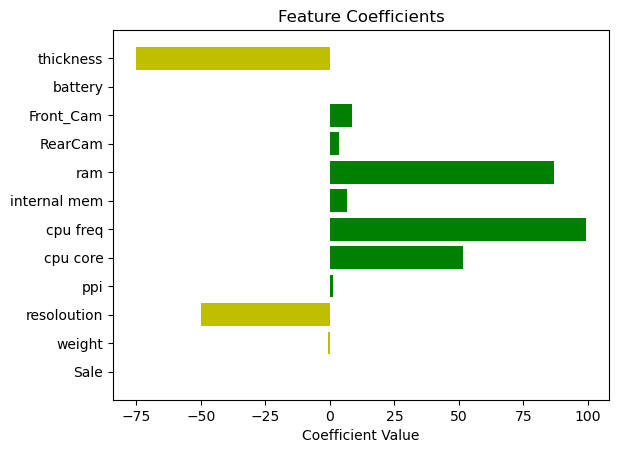

In [48]:
# Fit the model to your data
model.fit(X_train, y_train)
# Get the coefficients (weights) and the intercept
coefficients, intercept = model.coef_, model.intercept_
# Print the coefficients and intercept
print("Intercept:", intercept)
print("Coefficients:", coefficients)
# Define colors for positive and negative coefficients
colors = ['g' if c >= 0 else 'y' for c in coefficients]
# Create a horizontal barplot
plt.barh(X.columns, coefficients, color=colors)
plt.xlabel('Coefficient Value')
plt.title('Feature Coefficients')
plt.show()


# Residual plot & its kdeplot.

## These residual plots are very usefull in determing if Linear Regression was right choice.


 - If we have a perfect model. Then our resudials would be zero.<br>


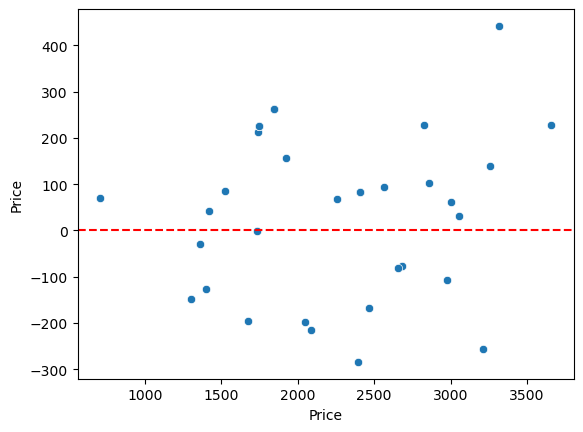

In [23]:
y_pred = lr.predict(X_test)
residuals = y_test - y_pred
sns.scatterplot(x=y_test,y=residuals)
plt.axhline(y=0, color='r', linestyle='--')

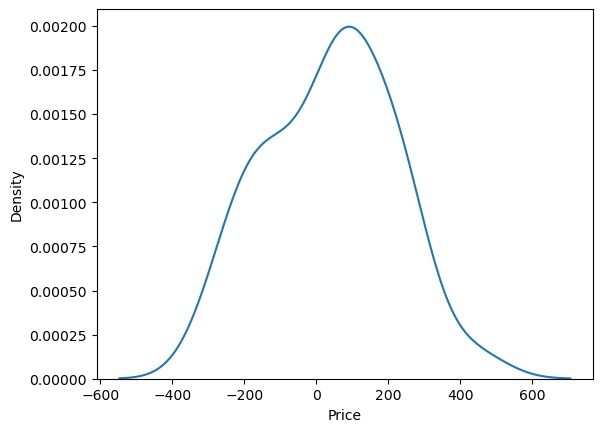

In [24]:
# Looks normally distributed to me.....
sns.kdeplot(residuals)
plt.show()

In [25]:
# Skewed by a bit is fine...
residuals.skew()

0.0006502777542892584

# Heteroskedasticity  Test

 Heteroskedasticity (or heteroscedasticity) refers to the situation in which the variability of the error terms (residuals) in a regression model is not constant across all levels of the independent variable(s). In simpler terms, the spread or dispersion of the residuals changes as the values of the independent variable(s) change.

 Heteroskedasticity violates one of the assumptions of classical linear regression, which assumes homoskedasticity (constant variance of residuals). When heteroskedasticity is present, it can lead to inefficient estimates of the regression coefficients, and standard errors may be biased.

In [71]:
from statsmodels.stats.diagnostic import het_breuschpagan
# Perform the Breusch-Pagan test
bp_test_statistic, bp_p_value, _, _ = het_breuschpagan(sm.OLS(y, sm.add_constant(X)).fit().resid, X)
# Print results and interpret
print(f"Breusch-Pagan Test Statistic: {bp_test_statistic}\nP-value: {bp_p_value}")
print("Reject the null hypothesis. Heteroskedasticity may be present." if bp_p_value < 0.05 else "Fail to reject. No strong evidence of heteroskedasticity.")


Breusch-Pagan Test Statistic: 78.1639133601368
P-value: 3.338494467430832e-12
Reject the null hypothesis. Heteroskedasticity may be present.


# Test for Auto-Correlation

  The Durbin-Watson statistic ranges from 0 to 4, and values around 2 indicate no autocorrelation. Values significantly below 2 may suggest positive autocorrelation, while values significantly above 2 may suggest negative autocorrelation. The thresholds for significance may vary depending on the context and the specific characteristics of the data.

In [72]:
from statsmodels.stats.stattools import durbin_watson
# Perform the Durbin-Watson test
dw_statistic = durbin_watson(y_test - LinearRegression().fit(X_train, y_train).predict(X_test))
# Print results and interpretation
print(f"Durbin-Watson Statistic: {dw_statistic}")
print("Positive autocorrelation may be present." if dw_statistic < 1.5 else "Negative autocorrelation may be present." if dw_statistic > 2.5 else "Autocorrelation is likely not present.")

Durbin-Watson Statistic: 2.258843891375515
Autocorrelation is likely not present.


# OUTCOME:- 
### "Based on the data, CPU Frequency exhibits the highest coefficient value, indicating the strongest impact, followed by RAM."